In [1]:
import nltk
import string
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
from sklearn.metrics import roc_curve, roc_auc_score
from nltk.corpus import words
from collections import Counter
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


**Note for if i will try to improve my results or for someone who will take as baseline**

My botleneck is preprocessing. My cleaning method is maybe too harsh, it cleans all garbage, but it also cleans words that my have some meaning, + i only count words that gramatically correct, meaning all of the abbreviations are lost along side with some slang and stuff. But even with that in my mind, my model performs on the same level as most of what i saw on the internet (YouTube and etc), which i think means that most of the words that i drop actully were garbage.

The other thing that will improve the performance is using pretrained model or at least pretrained Embedding layer

P. S. usually people's vocabulary is around 15 000, mine is around 7 000, and it still performs on the same level.

**Section 1: Preprocessing and Data Explaration**

Ive done most of my data exploration after the data was processed, to see what words are in the vocabulary and all. So i've started from preprocessing.

In [2]:
train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv') 
test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
test_ids = test['id'].copy()

In [3]:
train_set, val_set = train_test_split(train, test_size = 0.2)

print(train_set['target'].value_counts())
print(val_set['target'].value_counts())
#the ration seems fine

0    3493
1    2597
Name: target, dtype: int64
0    849
1    674
Name: target, dtype: int64


In [4]:
# i will add 'http' in stop words anyways, and delte them from text,
# so i will fill the missing entries with that so the NaN values will not cause me any erors
train_set['keyword'].fillna('http', inplace = True)
val_set['keyword'].fillna('http', inplace = True)
test['keyword'].fillna('http', inplace = True)

# So the reasoning behind adding the keyword to the text is that 
# we will emphasize a certain feature (word) by having more of them in the object
train_set['all_words'] = train_set['text'] + ' ' + train_set['keyword']
val_set['all_words'] = val_set['text'] + ' ' + val_set['keyword']
test['all_words'] = test['text'] + ' ' + test['keyword']


In [5]:
val_labels = val_set['target'].copy()
val_labels = val_labels.to_numpy()
val_set = val_set['all_words'].copy()
train_labels = train_set['target'].copy()
train_labels = train_labels.to_numpy()
train_set = train_set['all_words'].copy()
test = test['all_words'].copy()

In [6]:
word_set = set(words.words())
word_set.add('forrest') 
# i accidentally found that this word is not in the corpus which is weird. 
# Maybe there are more examples like that but it is too tedious to find, i couldnt bother 
stop_words = stopwords.words('english')
some_more_stop_words = ['http', 'https', 'cant', 'oh', 'b', 'rt','yeah', 'dont', 'bc', 
                        'cause', 'hello', 'wow', 'yo', 'mr', 'miss', 'ah', 'abc', 'aw', 
                        'aka', 'ahh', 'att', 'aa', 'aan', 'aa', 'aar', 'ay', 'and', 'aia', 
                        'akx','but', 'bye', 'com', 'ee', 'yay', 'yr', 'yh', 'ya', 'yet', 
                        'yyj', 'yyc', 'yup', 'ye', 'yea', 'yep', 'ohh', 'ovo', 'ok', 'ooh', 
                        'of', 'if', 'im', 'jez']

#most of the stop words i've added retroactively,
#when i saw that a lot of garbage came throught in vocabulary
stop_words.extend(some_more_stop_words)
stop_words = set(stop_words)

def custom_text_cleaner(test_sent):
    tokens = word_tokenize(test_sent)
    new_tokens = []
    
    for token in tokens:
        
        extra_in_word_bool = False
        
        if token not in word_set:
            if token.casefold() not in word_set:
                continue
        
        if token.casefold() in stop_words:
            continue
            
        
        new_tokens.append(token.casefold())
            
    return ' '.join(new_tokens)


def count_words(series):
    counts = Counter()
    for tweet in series.values:
        for word in tweet.split():
            counts[word] += 1
    return counts

In [7]:
train_tweets = train_set.apply(custom_text_cleaner)
val_tweets = val_set.apply(custom_text_cleaner)
test_tweets = test.apply(custom_text_cleaner)


feature_number = len(max(train_tweets, key=len).split())
vocab_counted = count_words(train_tweets) + count_words(val_tweets)
num_words_in_vocab = len(vocab_counted)

In [8]:
tokenizer = Tokenizer(num_words = num_words_in_vocab)
tokenizer.fit_on_texts(train_tweets)
word_index = tokenizer.word_index

In [9]:
#tokenizing, sequencing and pading 
train_sequences = tokenizer.texts_to_sequences(train_tweets)
train_padded = pad_sequences(train_sequences, maxlen = feature_number, padding = 'post')
val_sequences = tokenizer.texts_to_sequences(val_tweets)
val_padded = pad_sequences(val_sequences, maxlen = feature_number, padding = 'post')
test_sequences = tokenizer.texts_to_sequences(test_tweets)
test_padded = pad_sequences(test_sequences, maxlen = feature_number, padding = 'post')

**Section 2: Creating and Training Model**

In [10]:
sequential_nn_model = keras.models.Sequential()
sequential_nn_model.add(keras.layers.Embedding(num_words_in_vocab, 64, 
                                               input_length = feature_number, 
                                               mask_zero = True))
sequential_nn_model.add(keras.layers.GRU(128, dropout = 0.3, return_sequences = True))
sequential_nn_model.add(keras.layers.GRU(32, dropout = 0.1))
sequential_nn_model.add(keras.layers.Dense(1, activation = 'sigmoid'))

sequential_nn_model.summary()

2022-05-28 22:48:14.673914: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 13, 64)            429440    
_________________________________________________________________
gru (GRU)                    (None, 13, 128)           74496     
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                15552     
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 519,521
Trainable params: 519,521
Non-trainable params: 0
_________________________________________________________________


In [11]:
sequential_nn_model.compile(loss = 'binary_crossentropy',
                            optimizer = tf.keras.optimizers.Adam(learning_rate = 3e-3),
                            metrics = ['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint("best_model_1.h5")

history = sequential_nn_model.fit(train_padded, train_labels, epochs = 5,
                                  validation_data = (val_padded, val_labels),
                                  callbacks = [checkpoint_cb])

sequential_nn_model = keras.models.load_model("best_model_1.h5") #a way of early stoping

Epoch 1/5


2022-05-28 22:48:16.690040: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


191/191 [==============================] - 18s 50ms/step - loss: 0.5398 - accuracy: 0.7332 - val_loss: 0.5015 - val_accuracy: 0.7689
Epoch 2/5
191/191 [==============================] - 8s 41ms/step - loss: 0.3686 - accuracy: 0.8448 - val_loss: 0.5949 - val_accuracy: 0.7728
Epoch 3/5
191/191 [==============================] - 7s 38ms/step - loss: 0.2665 - accuracy: 0.8961 - val_loss: 0.6267 - val_accuracy: 0.7623
Epoch 4/5
191/191 [==============================] - 7s 36ms/step - loss: 0.2027 - accuracy: 0.9258 - val_loss: 0.7307 - val_accuracy: 0.7367
Epoch 5/5
191/191 [==============================] - 7s 36ms/step - loss: 0.1579 - accuracy: 0.9424 - val_loss: 0.8461 - val_accuracy: 0.7308


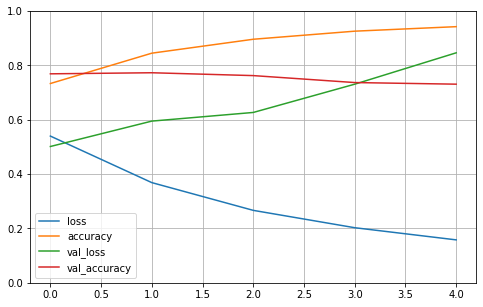

In [12]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

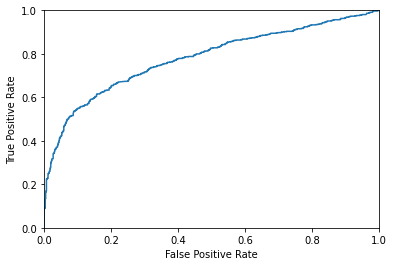

In [13]:
y_val_proba = sequential_nn_model.predict(val_padded).ravel()
fpr, tpr, thresholds = roc_curve(val_labels, y_val_proba)

def plot_roc_curve(fpr,tpr): 
    plt.plot(fpr,tpr)
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate') 
    plt.show()    

plot_roc_curve (fpr,tpr) 

In [14]:
predictions = sequential_nn_model.predict(test_padded)
predictions = tf.squeeze(tf.round(predictions))
predictions = tf.round(predictions.numpy())

In [15]:
sub = pd.DataFrame({'id' : test_ids,'target' : predictions})
sub['target'] = sub['target'].apply(int)
sub.to_csv('submission.csv',  index = False)
print(sub.head())

   id  target
0   0       0
1   2       1
2   3       1
3   9       0
4  11       1
